# gpOptimizer: Single-Task

In [1]:
## First, install the right version of gpCAM
#!pip install gpcam==8.1.13

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time


%load_ext autoreload
%autoreload 2

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

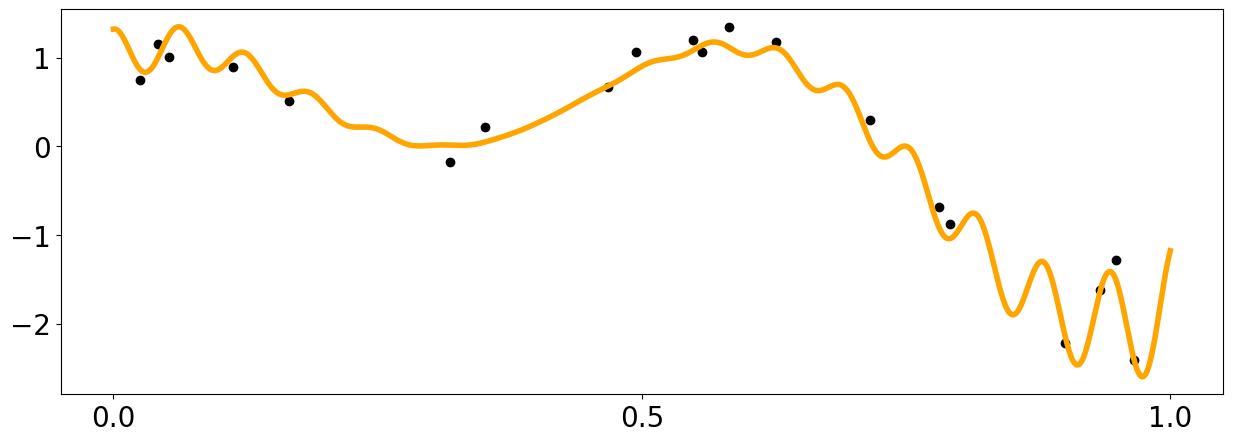

In [4]:
x = np.linspace(0,600,1000)
def f1(x):
    return np.sin(5. * x) + np.cos(10. * x) + (2.* (x-0.4)**2) * np.cos(100. * x)
 
x_data = np.random.rand(20).reshape(-1,1) 
y_data = f1(x_data[:,0]) + (np.random.rand(len(x_data))-0.5) * 0.5

plt.figure(figsize = (15,5))
plt.xticks([0.,0.5,1.0])
plt.yticks([-2,-1,0.,1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(x_pred1D,f1(x_pred1D), color = 'orange', linewidth = 4)
plt.scatter(x_data[:,0],y_data, color = 'black')

## Customizing the Gaussian Process

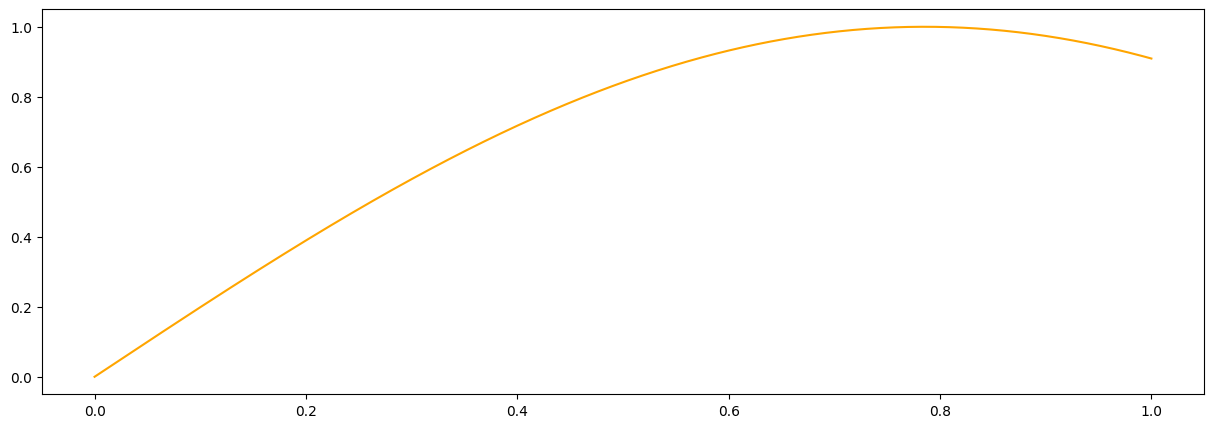

In [5]:
from gpcam.gp_kernels import *
def my_noise(x,hps):
    #This is a simple noise function, but can be arbitrarily complex using many hyperparameters.
    #The noise function always has to return a matrix, because the noise can have covariances.
    return np.zeros((len(x))) + hps[2]

#stationary
def skernel(x1,x2,hps):
    #The kernel follows the mathematical definition of a kernel. This
    #means there is no limit to the variety of kernels you can define.
    d = get_distance_matrix(x1,x2)
    return hps[0] * matern_kernel_diff1(d,hps[1])


def meanf(x, hps):
    #This ios a simple mean function but it can be arbitrarily complex using many hyperparameters.
    return np.sin(hps[3] * x[:,0])
#it is a good idea to plot the prior mean function to make sure we did not mess up
plt.figure(figsize = (15,5))
plt.plot(x_pred1D,meanf(x_pred1D, np.array([1.,1.,5.0,2.])), color = 'orange', label = 'task1')

## Initialization and Different Training Options

In [6]:


my_gp1 = GPOptimizer(x_data,y_data,
            init_hyperparameters = np.ones((4))/10.,  # We need enough of those for kernel, noise, and prior mean functions
            noise_variances=np.ones(y_data.shape) * 0.01, # providing noise variances and a noise function will raise a warning 
            compute_device='cpu', 
            gp_kernel_function=skernel, 
            gp_kernel_function_grad=None, 
            gp_mean_function=meanf, 
            gp_mean_function_grad=None,
            #gp_noise_function=my_noise,
            gp2Scale = False,
            calc_inv=False, 
            ram_economy=False, 
            args=None,
            )

hps_bounds = np.array([[0.01,10.], #signal variance for the kernel
                       [0.01,10.], #length scale for the kernel
                       [0.001,1.],  #noise
                       [0.01,1.]  #mean
                      ])


my_gp1.tell(x_data, y_data, noise_variances=np.ones(y_data.shape) * 0.01)
print("Standard Training")
my_gp1.train(hyperparameter_bounds=hps_bounds)
print("Global Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='global')
print("hps: ", my_gp1.get_hyperparameters())
print("Local Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='local')
print(my_gp1.get_hyperparameters())
print("MCMC Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='mcmc', max_iter=1000)
print("HGDL Training")
my_gp1.train(hyperparameter_bounds=hps_bounds, method='hgdl', max_iter=10)


Standard Training
Global Training
hps:  [1.27683872 0.06187243 0.39771896 0.01001275]
Local Training
[1.27687643 0.06178181 0.39771896 0.01001273]
MCMC Training
HGDL Training


/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/fvgp/gp_training.py:234: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  OptimumEvaluation = minimize(
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


array([1.28079689, 0.06183364, 0.73887037, 0.01      ])

In [7]:
my_gp1.get_data()

{'input dim': 1,
 'x data': array([[0.16571768],
        [0.0248022 ],
        [0.54842476],
        [0.46779918],
        [0.11314078],
        [0.96546299],
        [0.04222058],
        [0.49424681],
        [0.79130395],
        [0.90057633],
        [0.94828029],
        [0.3189163 ],
        [0.93315442],
        [0.55646775],
        [0.71618849],
        [0.05284063],
        [0.78088045],
        [0.35194317],
        [0.62674119],
        [0.58239644]]),
 'y data': array([ 0.51225763,  0.74195183,  1.19246637,  0.6629926 ,  0.89506671,
        -2.41003559,  1.15059592,  1.06041675, -0.87420044, -2.21181792,
        -1.28608127, -0.18266726, -1.62074487,  1.05787087,  0.29879563,
         1.00586425, -0.68217191,  0.21670912,  1.17116058,  1.34434132]),
 'measurement variances': array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
 'hyperparameters': array([1.28079689, 0.06183364, 0.73887037, 0

## Asynchronous Training
Train asynchronously on a remote server or locally. 
You can also start a bunch of different trainings on different computers.
This training will continue without any signs of life until you call 'my_gp1.stop_training(opt_obj)'

In [14]:
my_gp1.set_hyperparameters(np.ones((4))/10.)
opt_obj = my_gp1.train_async(hyperparameter_bounds=hps_bounds)
for i in range(100):
    time.sleep(0.1)
    my_gp1.update_hyperparameters(opt_obj)
    print(my_gp1.get_hyperparameters())
    print("")
my_gp1.stop_training(opt_obj)

/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38099 instead
  warnings.warn(


[0.1 0.1 0.1 0.1]

[0.1 0.1 0.1 0.1]

[0.1 0.1 0.1 0.1]

[0.1 0.1 0.1 0.1]



/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,
/home/marcus/VirtualEnvironments/gpcam_dev/lib/python3.10/site-packages/hgdl/local_methods/local_optimizer.py:94: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(d.func, x0, args=args, method=method, jac=grad, hess=hess,


[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0.06183362 0.99281245 0.01      ]

[1.2807967  0

## Plotting the Result

0.2548983406119667
(np.float64(0.982729027453312), np.float64(0.9184924477826006))


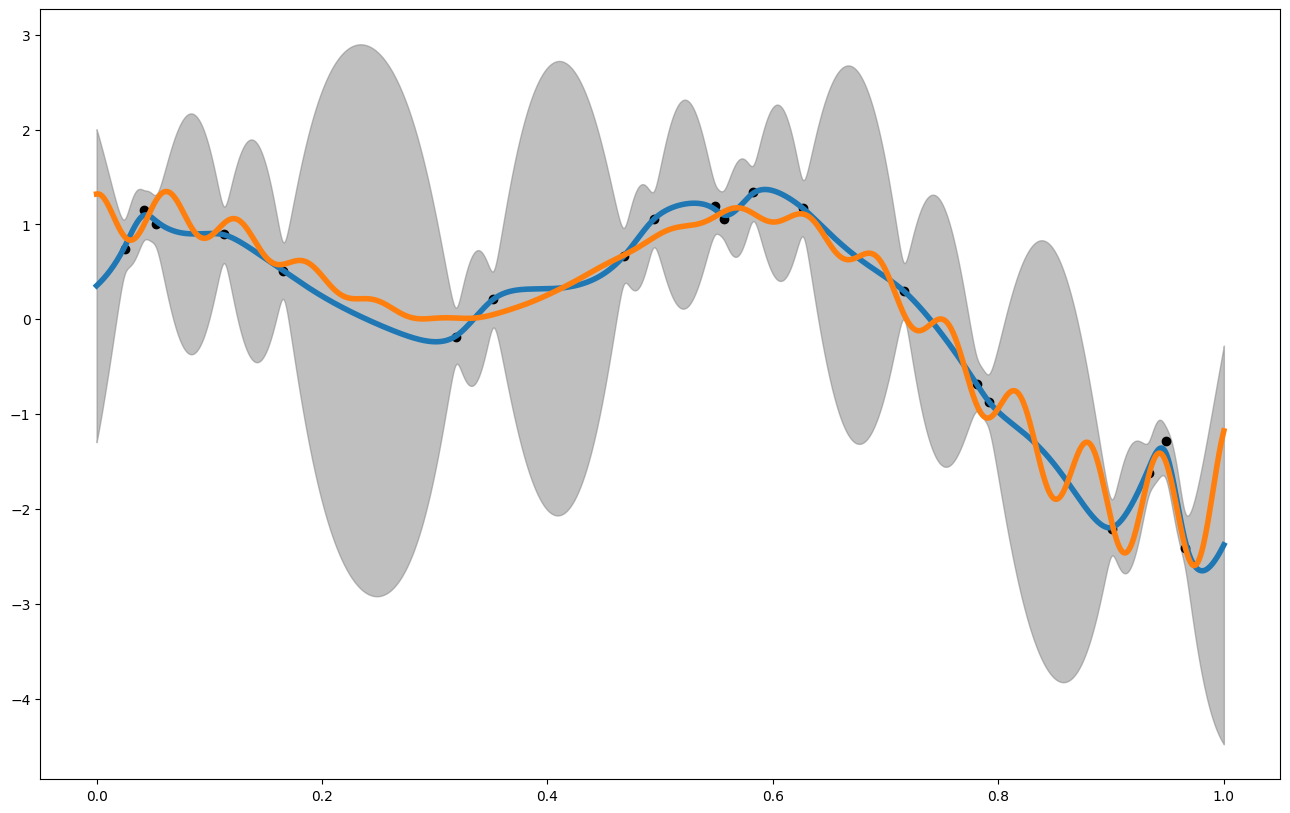

In [9]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp1.posterior_mean(x_pred.reshape(-1,1))["f(x)"]
var1 =  my_gp1.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(x_data,y_data, color = 'black')


##looking at some validation metrics
print(my_gp1.rmse(x_pred1D,f1(x_pred1D)))
print(my_gp1.crps(x_pred1D,f1(x_pred1D)))

In [10]:
#We can ask mutual information and total correlation there is given some test data
x_test = np.array([[0.45],[0.45]])
print("Mutual Information: ",my_gp1.gp_mutual_information(x_test))
print("Total Correlation : ",my_gp1.gp_total_correlation(x_test))

Mutual Information:  {'x': array([[0.45],
       [0.45]]), 'mutual information': np.float64(1.0304592953360014)}
Total Correlation :  {'x': array([[0.45],
       [0.45]]), 'total correlation': np.float64(11.169259811656177)}


In [11]:
next_point = my_gp1.ask(np.array([[0.,1.]]))
print(next_point)

{'x': array([[0.2416212]]), 'f(x)': array([0.92834383]), 'opt_obj': None}
